# Calculating Monthly Overdose deaths from CDC data
Author: Samir Akre
Last Updated: Jan 3 2021

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.load_data as ld
import src.defilter_data as dd
import src.estimate_error as ee
import importlib
import scipy.stats as stats

## Import and clean data
- 'predicted_val' column is 12-month rolling sum of monthly overdose deaths
- 'Deaths' column are the imputed monthly overdose deaths

In [38]:
importlib.reload(dd)
importlib.reload(ld)
data = ld.load_data().dropna(how='all')
data

/Users/akre96/Code/cdc_overdose/src/load_data.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_overdose['timestamp'] = pd.to_datetime(cdc_overdose['year'].astype(str)  + cdc_overdose['month'], format='%Y%B')


,timestamp,location,predicted_val,Deaths
79,2015-01-01,Alabama,742.0,65.0
78,2015-02-01,Alabama,749.0,60.0
82,2015-03-01,Alabama,758.0,79.0
75,2015-04-01,Alabama,764.0,69.0
83,2015-05-01,Alabama,782.0,74.0
...,...,...,...,...
3894,2020-11-01,Wyoming,109.0,NaN
3887,2020-12-01,Wyoming,101.0,NaN
3898,2021-01-01,Wyoming,97.0,NaN
3897,2021-02-01,Wyoming,99.0,NaN


## Impute/Predict 2020 monthly data
- 11 months of monthly death data used to "unroll" to 12 month rolling sum reported for 2020 months

In [78]:
k = 12 # 12 month rolling sum
# NOTE: Set date such that there are 2 or 3 predictions that aren't exact in the monthly graphs
time_filt = data[data.timestamp >= pd.to_datetime('2018-12-01')]
time_filt['raw_predicted_val'] = np.nan
for loc in time_filt['location'].unique():
    truth = time_filt.loc[time_filt.location == loc, 'Deaths'].values
    if time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].empty:
        continue
    try:
        pred = dd.unroll_sum(time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].values, k, truth[:11])
    except: 
        print(loc)
    time_filt.loc[time_filt.location == loc, 'raw_predicted_val'] = pred
time_filt['raw_predicted_val'] = time_filt['raw_predicted_val'].astype(float)

United States


<ipython-input-78-50a534afafbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filt['raw_predicted_val'] = np.nan
/Users/akre96/Code/cdc_overdose/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-78-50a534afafbc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [79]:
time_filt

,timestamp,location,predicted_val,Deaths,raw_predicted_val
113,2018-12-01,Alabama,753.0,80.0,80.0
127,2019-01-01,Alabama,736.0,41.0,41.0
126,2019-02-01,Alabama,715.0,56.0,56.0
130,2019-03-01,Alabama,713.0,68.0,68.0
123,2019-04-01,Alabama,712.0,63.0,63.0
...,...,...,...,...,...
3894,2020-11-01,Wyoming,109.0,NaN,7.0
3887,2020-12-01,Wyoming,101.0,NaN,3.0
3898,2021-01-01,Wyoming,97.0,NaN,8.0
3897,2021-02-01,Wyoming,99.0,NaN,8.0


In [80]:
truth, pred

(array([ 3. ,  7. ,  4. , 10. ,  3. ,  4. ,  7. ,  7. ,  7. ,  7.5,  8.5,
         4. , 11. ,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan]),
 array([ 3. ,  7. ,  4. , 10. ,  3. ,  4. ,  7. ,  7. ,  7. ,  7.5,  8.5,
        -3. , 11. , 12. ,  6. , 11. ,  5. ,  9. ,  3. , 11. ,  7. , 15.5,
        11.5,  7. ,  3. ,  8. ,  8. ,  5. ]))

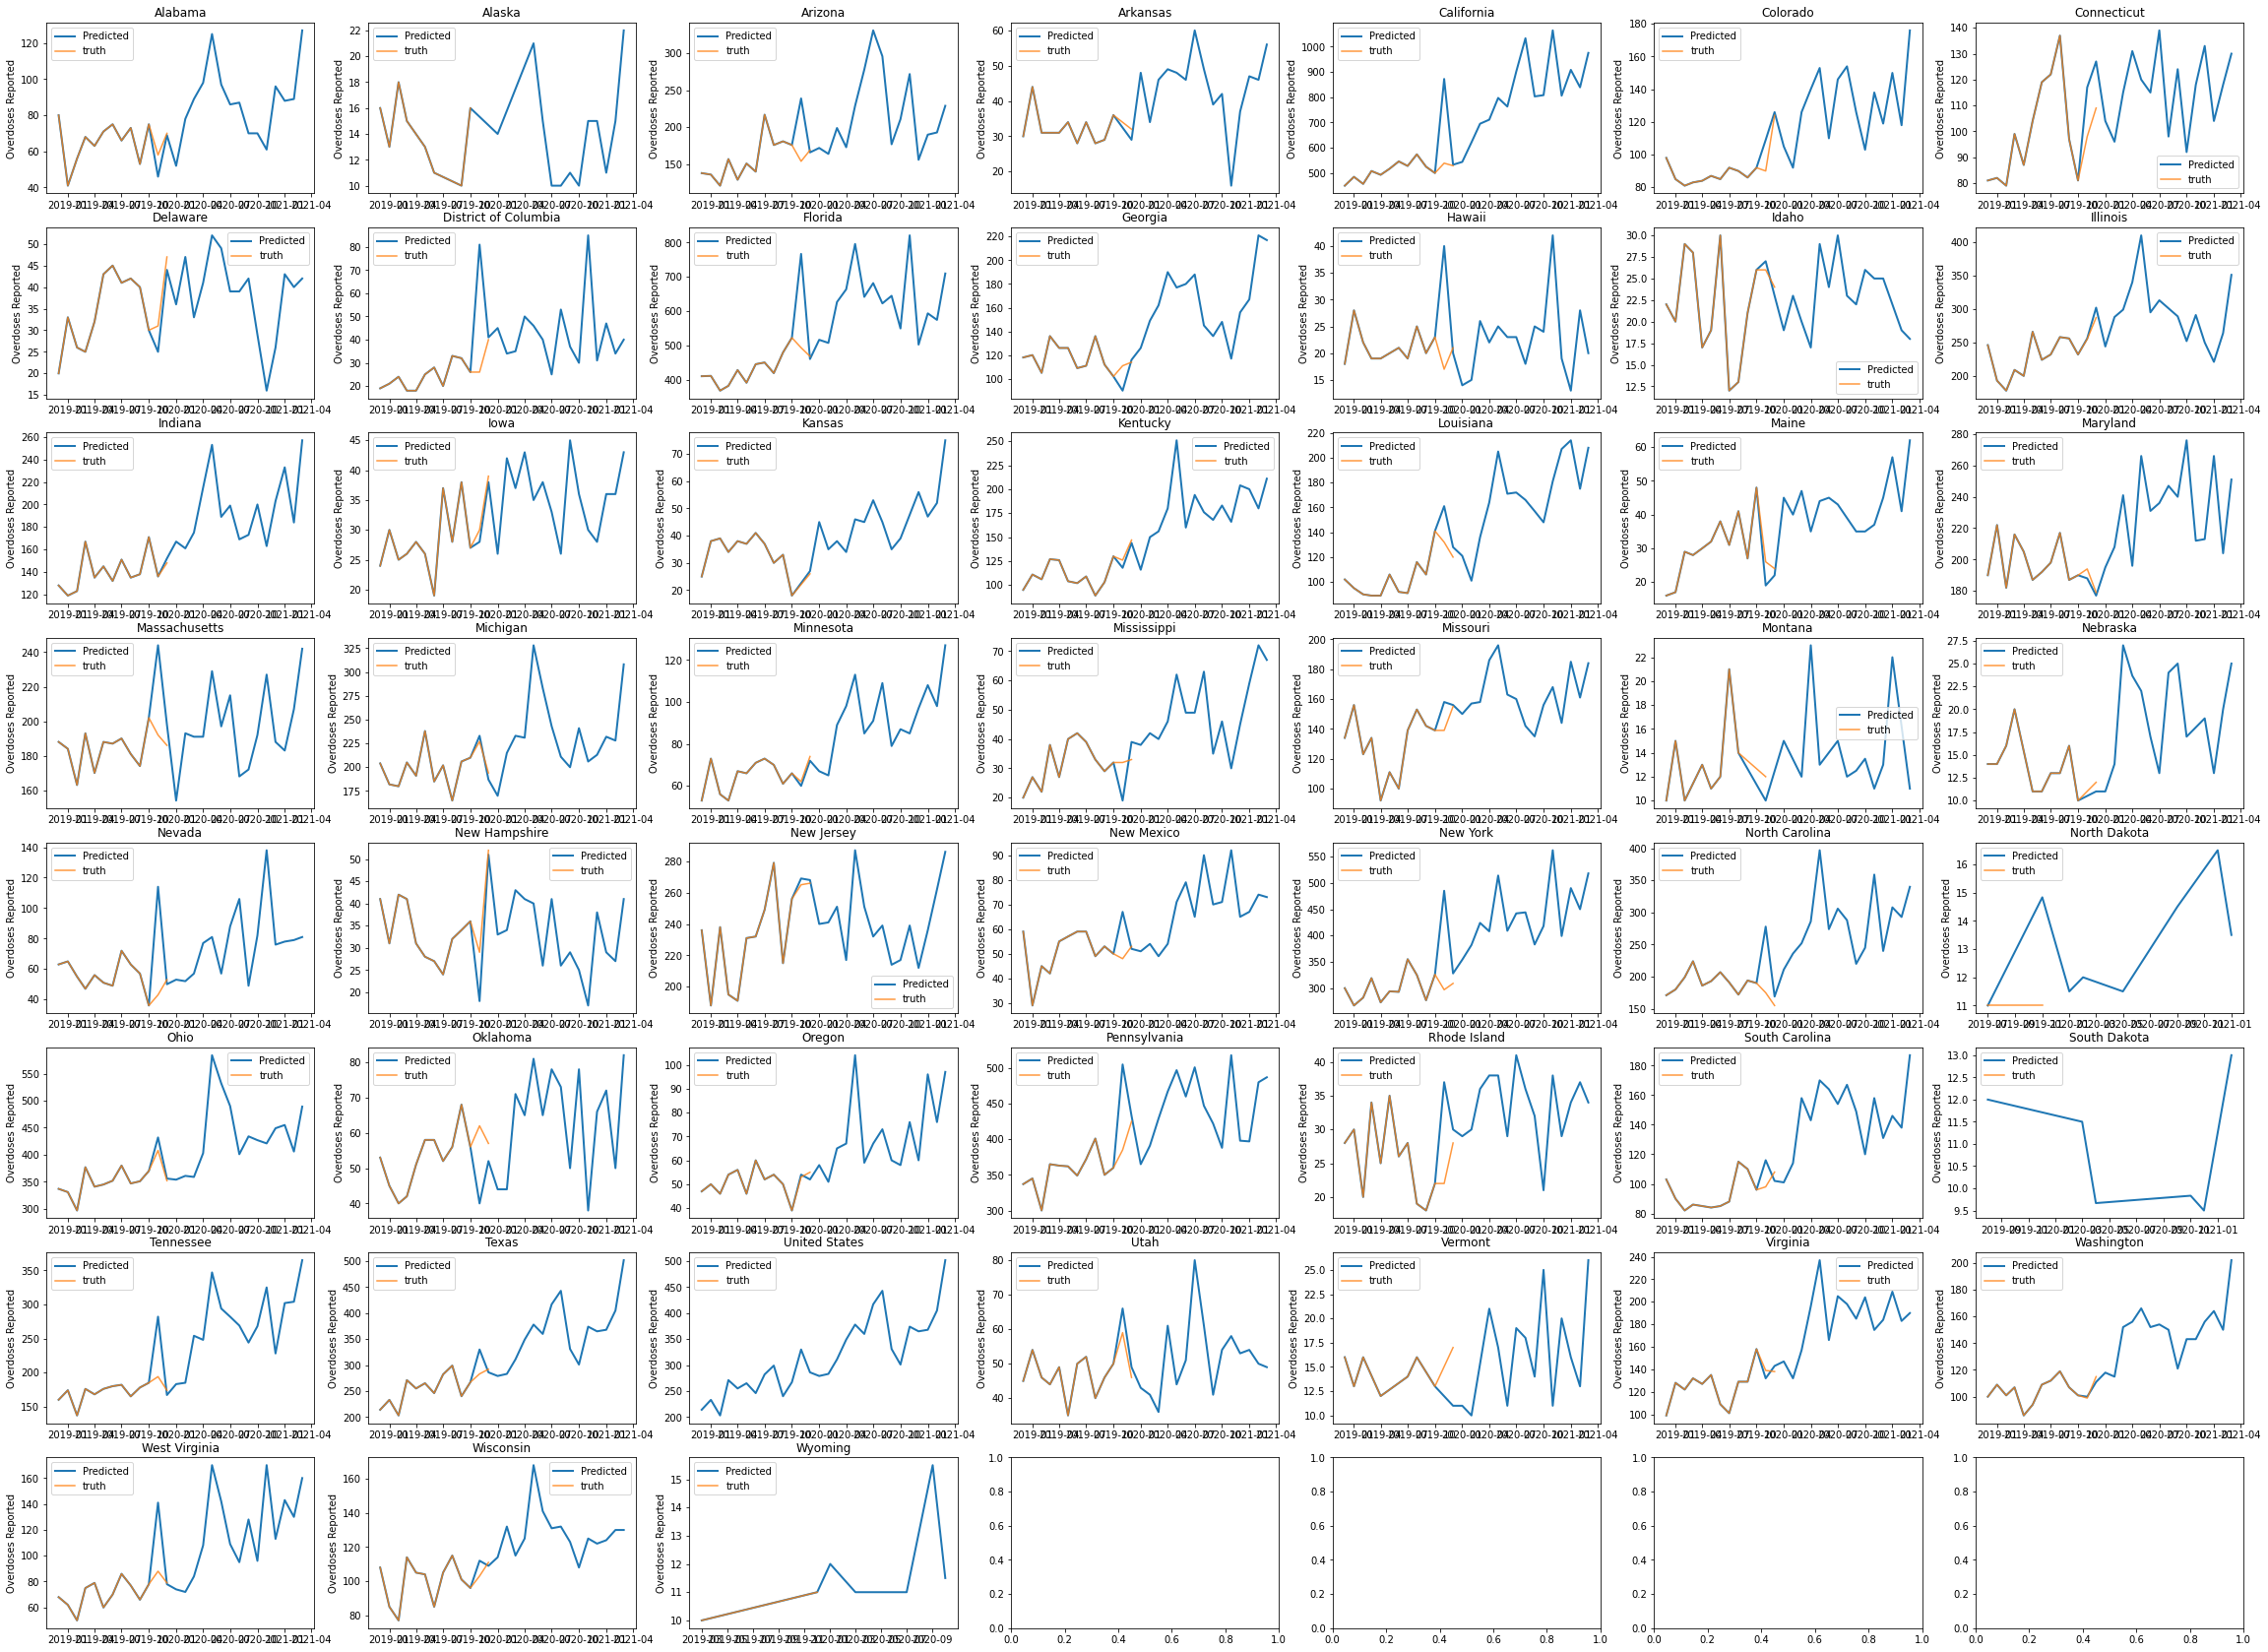

In [81]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in time_filt.groupby('location'):
    ax=axes.flatten()[i]
    filt_data = loc_data.copy()
    # Hides values less than 10 from plot
    for col in ['raw_predicted_val', 'Deaths']:
        filt_data.loc[filt_data[col] <= 9] = np.nan
    sns.lineplot(
        x='timestamp',
        y='raw_predicted_val',
        data=filt_data,
        label='Predicted',
        markers=True,
        lw=2,
        ax=ax
    )
    sns.lineplot(
        x='timestamp',
        y='Deaths',
        data=filt_data,
        label='truth',
        markers=True,
        alpha=.8,
        ax=ax
    )
    ax.set_ylabel('Overdoses Reported')
    ax.set_title(loc)
    ax.set_xlabel('')
    i+=1

In [83]:
time_filt[[
    'location', 'Deaths', 'timestamp', 'raw_predicted_val'
]].to_csv('output/monthly_overdose_computed_m3.csv', index=False)

In [74]:
time_filt[time_filt.Deaths.isna()].groupby('timestamp').raw_predicted_val.sum()

timestamp
2020-01-01    6356.0
2020-02-01    6522.0
2020-03-01    7356.0
2020-04-01    7703.0
2020-05-01    9192.0
2020-06-01    7888.0
2020-07-01    8850.0
2020-08-01    8606.0
2020-09-01    7718.0
2020-10-01    9382.0
2020-11-01    6976.0
2020-12-01    6930.0
Name: raw_predicted_val, dtype: float64

# Error Analysis

## Testing rolling sum unrolling method

In [47]:
time = np.arange(0, 12*6)/12
truth = np.random.randint(0, 1000, size=time.shape)
truth = np.sin(time*2) + 1
cumTruth = pd.Series(truth).rolling(window=12).sum().values
truth[:11]

array([1.        , 1.16589613, 1.3271947 , 1.47942554, 1.6183698 ,
       1.74017685, 1.84147098, 1.91944498, 1.9719379 , 1.99749499,
       1.99540796])

poorlyinformed


<AxesSubplot:>

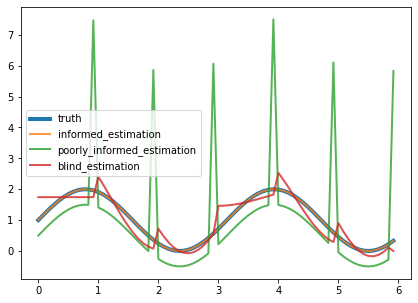

In [49]:
importlib.reload(dd)
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(
    x=time,
    y=truth,
    label='truth',
    lw=4,
    ax=ax
)
sns.lineplot(
    x=time,
    y=dd.unroll_sum(cumTruth[11:], 12, truth[:11]),
    label='informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)
print('poorlyinformed')
sns.lineplot(
    x=time,
    y=dd.unroll_sum(cumTruth[11:], 12, truth[:11] - .5),
    label='poorly_informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

sns.lineplot(
    x=time,
    y=dd.unroll_sum(cumTruth[12:], 12),
    label='blind_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)


## Discrepency in computed rolling sum of CDC monthly data vs reported rolling sum from CDC

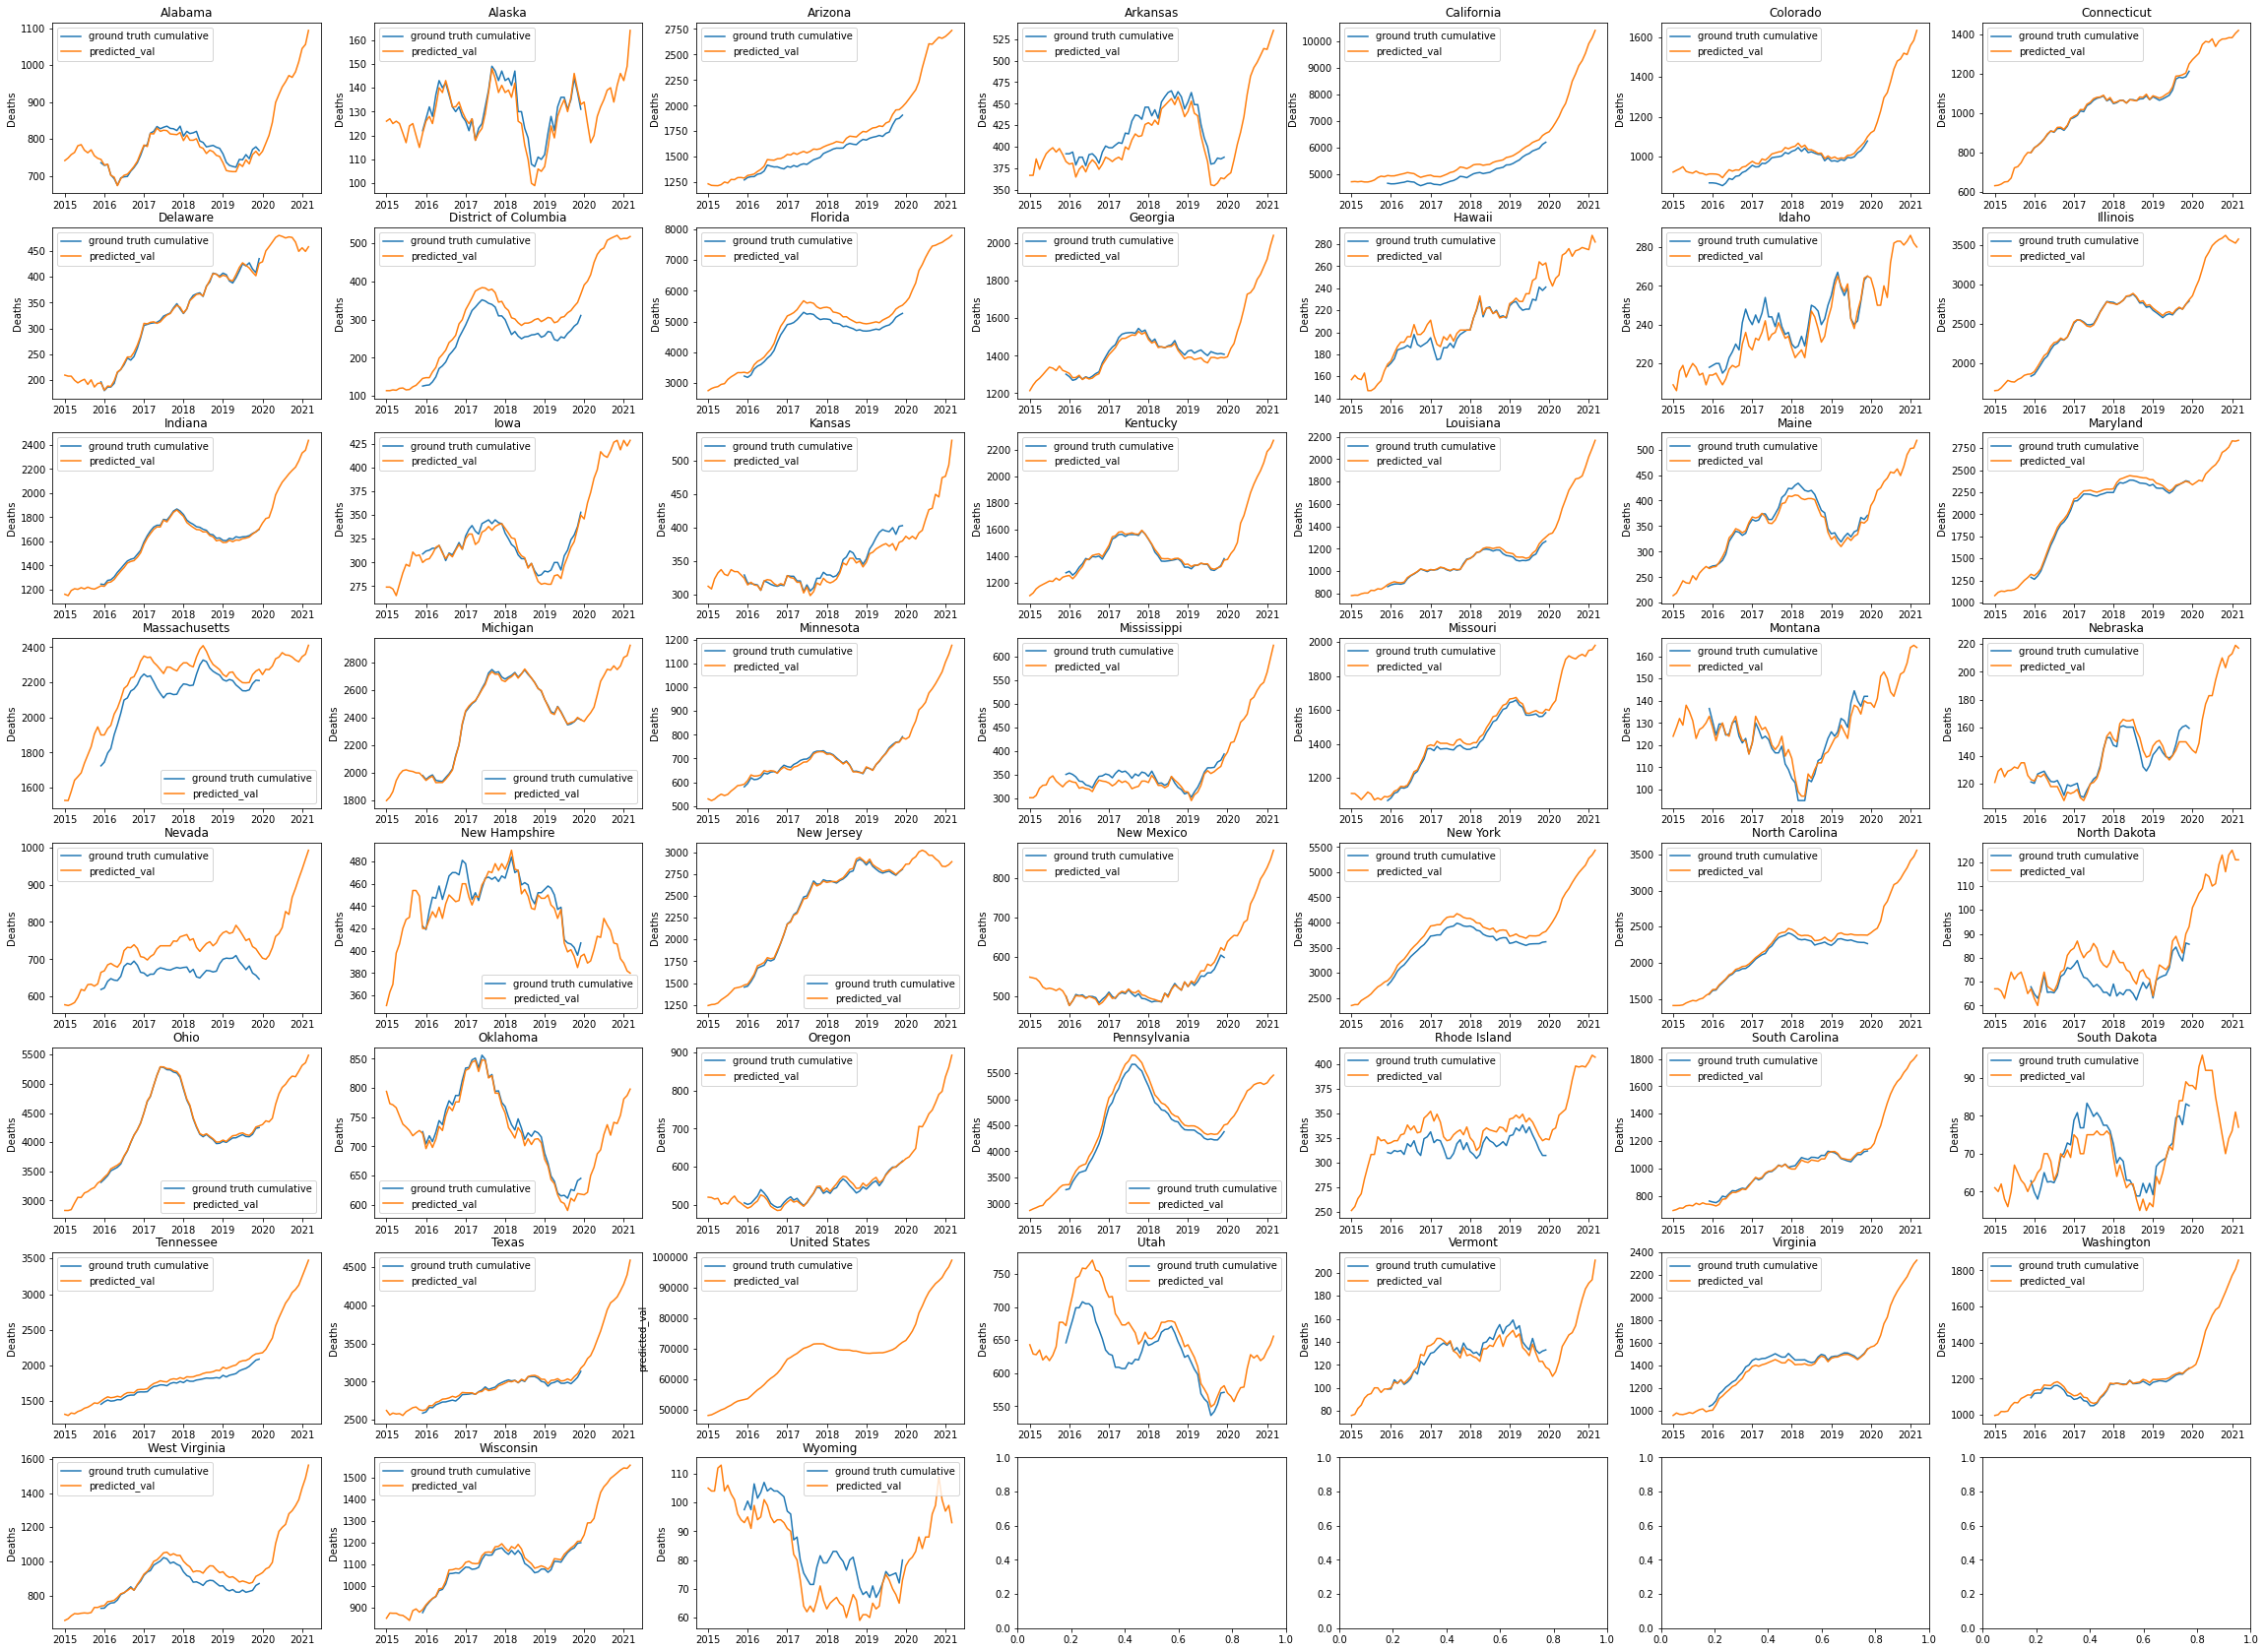

In [50]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in data.groupby('location'):
    ax=axes.flatten()[i]
    int_loc = loc_data.loc[loc_data.Deaths != 'Suppressed']
    int_loc.Deaths = int_loc.Deaths.rolling(12).sum()
    sns.lineplot(
        y='Deaths',
        x='timestamp',
        data=int_loc,
        label='ground truth cumulative',
        ax=ax,
    )
    sns.lineplot(
        y='predicted_val',
        label='predicted_val',
        x='timestamp',
        data=int_loc,
        ax=ax
    )
    ax.vlines(loc_data.loc[loc_data.Deaths == 'Suppressed', 'timestamp'], *ax.get_ylim(), lw=1, alpha=.5, color='red')
    ax.set_title(loc)
    ax.set_xlabel('')

    i+=1


## Calculate prediction error at n-months out from 11 months of ground truth data used

In [51]:
data.dropna().shape, data.shape

((3060, 4), (3900, 4))

In [52]:
importlib.reload(ee)
error_data = ee.calculate_error(data.dropna(), max_months_out = 15)
error_data.to_csv('output/full_error.csv', index=False)
error_data

,location,pred_timestamp,truth,error,pred,percent_error,month_out
0,Alabama,2015-12-01,51.0,-9.0,60.0,17.647059,1
765,Alabama,2016-01-01,58.0,-1.0,59.0,1.724138,1
1,Alabama,2016-01-01,58.0,8.0,50.0,13.793103,2
1530,Alabama,2016-02-01,62.0,-1.0,63.0,1.612903,1
766,Alabama,2016-02-01,62.0,0.0,62.0,0.000000,2
...,...,...,...,...,...,...,...
26008,Wyoming,2019-10-01,8.5,-0.5,9.0,5.882353,14
25244,Wyoming,2019-10-01,8.5,-0.5,9.0,5.882353,15
26773,Wyoming,2019-11-01,4.0,1.0,3.0,25.000000,14
26009,Wyoming,2019-11-01,4.0,1.0,3.0,25.000000,15


In [53]:
error_data[~error_data.error.isna()].pred_timestamp.nunique()

49

In [54]:
error_data.groupby('month_out').error.describe()

,count,mean,std,min,25%,50%,75%,max
month_out,,,,,,,,
1,1785.0,-26.784874,68.241835,-385.0,-28.0,-4.500000,5.000000,59.0
2,1785.0,-0.180392,5.571844,-34.0,-3.0,0.000000,2.000000,34.0
3,1785.0,-0.173669,5.549377,-34.0,-3.0,0.000000,2.666667,34.0
4,1785.0,-0.183754,5.587925,-34.0,-3.0,0.000000,2.666667,34.0
5,1785.0,-0.168627,5.552352,-34.0,-3.0,0.000000,2.500000,34.0
6,1785.0,-0.162465,5.564989,-34.0,-3.0,0.000000,3.000000,34.0
7,1785.0,-0.158543,5.582392,-34.0,-3.0,0.000000,3.000000,34.0
8,1785.0,-0.148459,5.579112,-34.0,-3.0,0.000000,3.000000,34.0
9,1785.0,-0.133333,5.553699,-34.0,-3.0,0.000000,3.000000,34.0


<AxesSubplot:xlabel='percent_error', ylabel='location'>

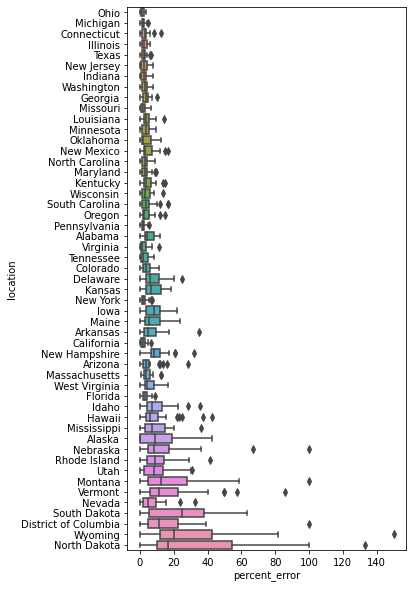

In [55]:
fig, ax = plt.subplots(figsize=(5,10))
m_last_error = error_data[error_data.month_out == 8]
order = error_data.groupby('location').percent_error.mean().sort_values().index
sns.boxplot(
    x='percent_error',
    y='location',
    data=m_last_error,
    order=order,
    ax=ax
)

## Summarize prediction error

In [56]:
stds = error_data.groupby(['location', 'month_out']).error.std()
abs_mean = error_data.groupby(['location', 'month_out']).error.apply(lambda x: np.mean(np.abs(x)))
mape = error_data.groupby(['location', 'month_out']).percent_error.apply(lambda x: np.mean(np.abs(x)))
std_pe = error_data.groupby(['location', 'month_out']).percent_error.std()
error_summary = pd.DataFrame(stds).rename(columns={'error': 'Std Error'}).reset_index().merge(
    pd.DataFrame(abs_mean).rename(columns={'error': 'Mean Absolute Error'}).reset_index()

).merge(
    pd.DataFrame(mape).rename(columns={'percent_error': 'Mean Absolute Percent Error'}).reset_index()
).merge(
    pd.DataFrame(std_pe).rename(columns={'percent_error': 'Std Percent Error'}).reset_index()
)
error_summary.to_csv('output/prediction_error_summary.csv', index=False)
error_summary

,location,month_out,Std Error,Mean Absolute Error,Mean Absolute Percent Error,Std Percent Error
0,Alabama,1,8.840986,8.771429,13.857440,10.417259
1,Alabama,2,4.206238,3.514286,5.527177,3.928743
2,Alabama,3,4.021580,3.285714,5.133089,3.763521
3,Alabama,4,4.026175,3.342857,5.272461,3.656645
4,Alabama,5,4.045331,3.342857,5.262457,3.660926
...,...,...,...,...,...,...
760,Wyoming,11,2.156873,1.642857,29.964905,31.077562
761,Wyoming,12,2.244508,1.714286,30.890075,31.079054
762,Wyoming,13,4.153818,10.214286,189.229138,110.329022
763,Wyoming,14,2.105914,1.542857,28.844342,27.441716
